In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import save_preprocessed_data_to_folder

In [2]:
# Courses Packages
from Utils.DataVisualization import PlotConfusionMatrix, PlotLabelsHistogram, PlotBinaryClassData

In [3]:
# import the data
from Utils.data_utils import load_data_from_folder
df = load_data_from_folder()
df = df.drop(columns=['file_name'])
print('shape =',df.shape)

df.describe()

shape = (6552, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,5570.000000,6552.000000,6552.000000,6552.000000,4990.000000,6552.000000,6552.000000,6228.000000,6552.000000,6552.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594176,32.877252,8767.901548,1.582964,41.412689,80.817895,3.307909,16.173710,0.780323,0.487812
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.697010,365.734414,12.065801,55.835966,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950968,481.792304,16.557652,77.339918,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               5570 non-null   float64
 1   Hardness         6552 non-null   float64
 2   Solids           6552 non-null   float64
 3   Chloramines      6552 non-null   float64
 4   Sulfate          4990 non-null   float64
 5   Conductivity     6552 non-null   float64
 6   Organic_carbon   6552 non-null   float64
 7   Trihalomethanes  6228 non-null   float64
 8   Turbidity        6552 non-null   float64
 9   Potability       6552 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 512.0 KB


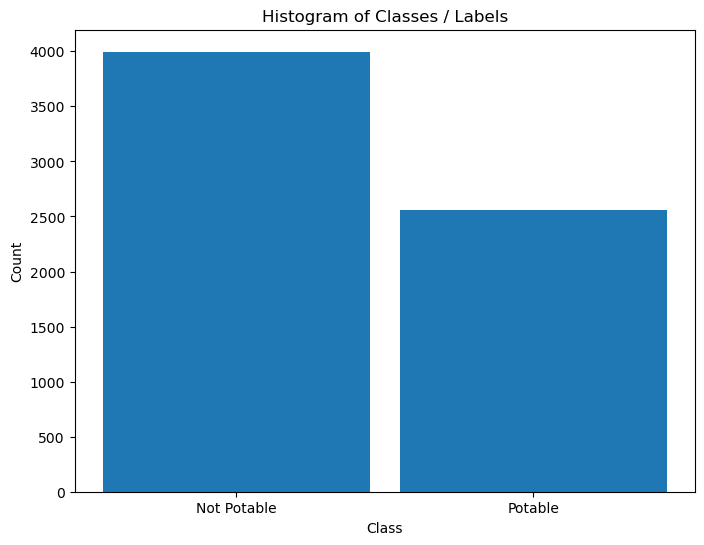

In [5]:
# Distribution of Labels
PlotLabelsHistogram(df['Potability'], lClass=['Not Potable', 'Potable']);

<Axes: >

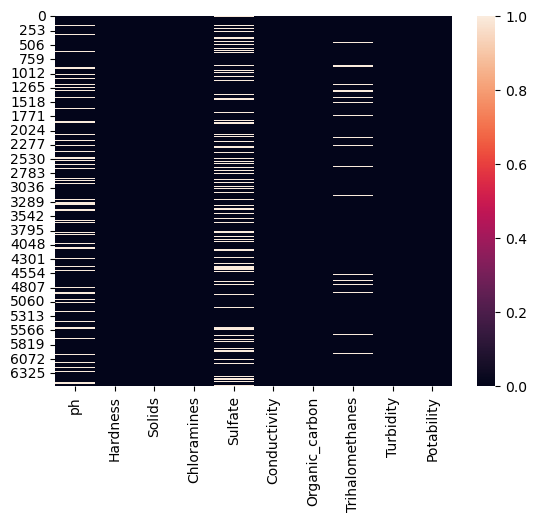

In [6]:
# clean data - before cleaning
sns.heatmap(df.isnull())

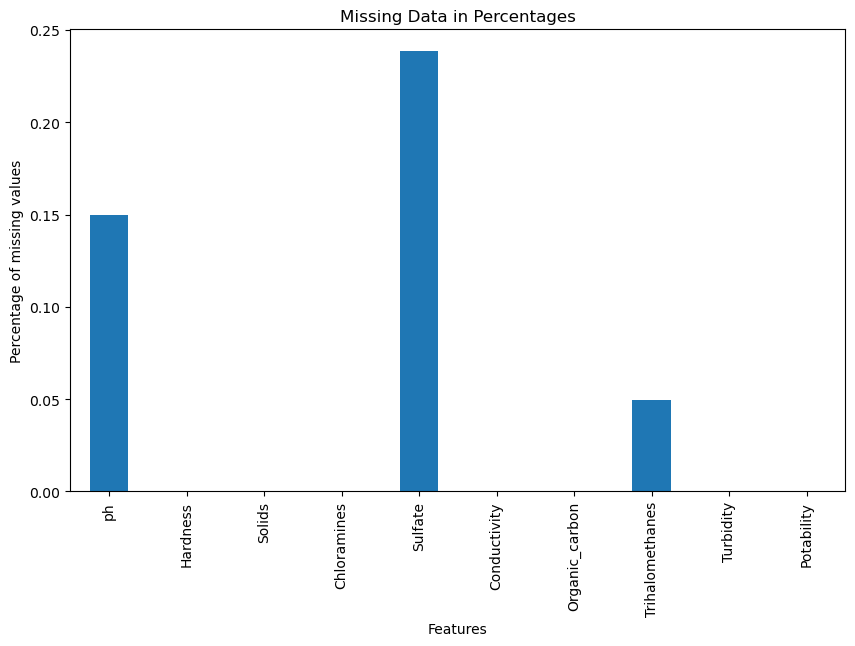

In [7]:
df.isnull().mean().plot.bar(figsize=(10,6)) 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Features') 
plt.title('Missing Data in Percentages');

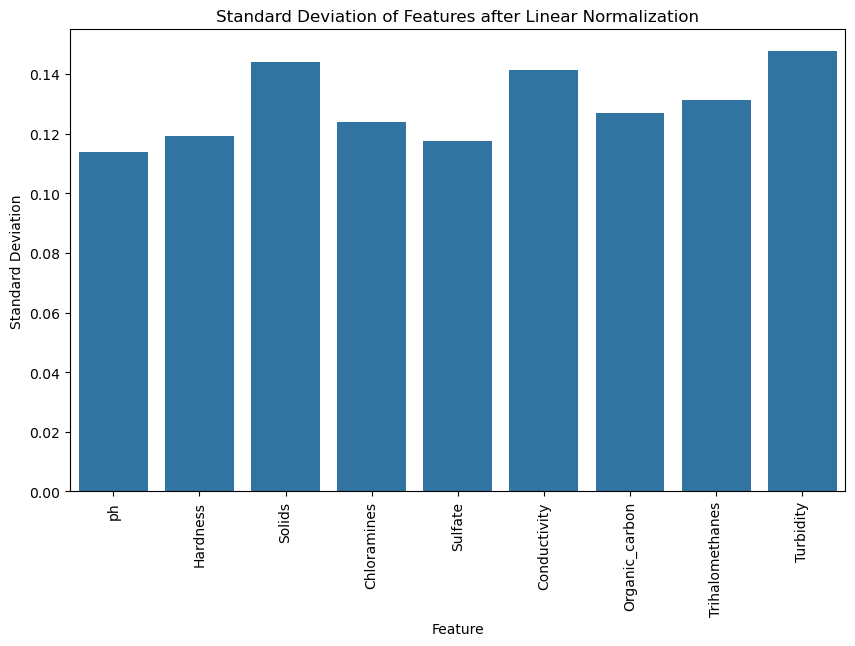

In [8]:
# Assuming df is your DataFrame containing the data
df_features = df.iloc[:, :-1]
normalized_df = (df_features - df_features.min()) / (df_features.max() - df_features.min())  # Linearly normalize each feature to have a max of 1
std = normalized_df.std()  # Calculate the standard deviation of each feature

# Plot the standard deviation of each feature after linear normalization
plt.figure(figsize=(10, 6))
sns.barplot(x=std.index, y=std.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Features after Linear Normalization')
plt.show()

(6552, 10)


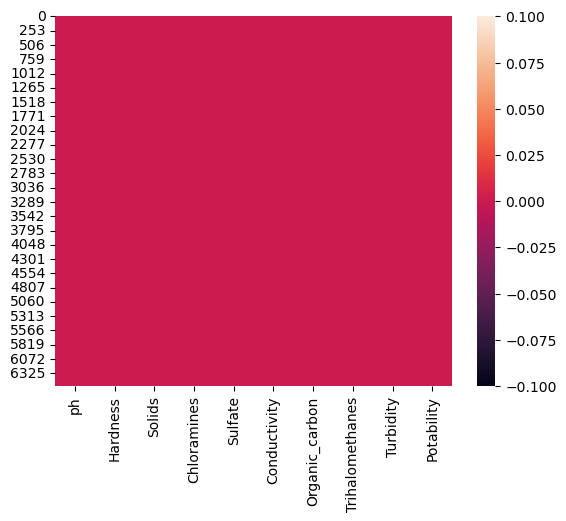

In [9]:
# clean data - after cleaning
df_clean = normalized_df.copy()
df_clean = pd.concat([df_clean, df['Potability']], axis=1) # add back potability column

# remove null rows
# df_clean.dropna(inplace=True)

# mean null rows
# df_clean.fillna(normalized_df.mean(), inplace=True)

# KNN Imputer
imputer = KNNImputer(n_neighbors=5) # Create a KNN imputer
df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# Iterative Imputer
# imputer = IterativeImputer(random_state=0, skip_complete=True)  # Create an IterativeImputer
# df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)


print(df_clean.shape)

sns.heatmap(df_clean.isnull());

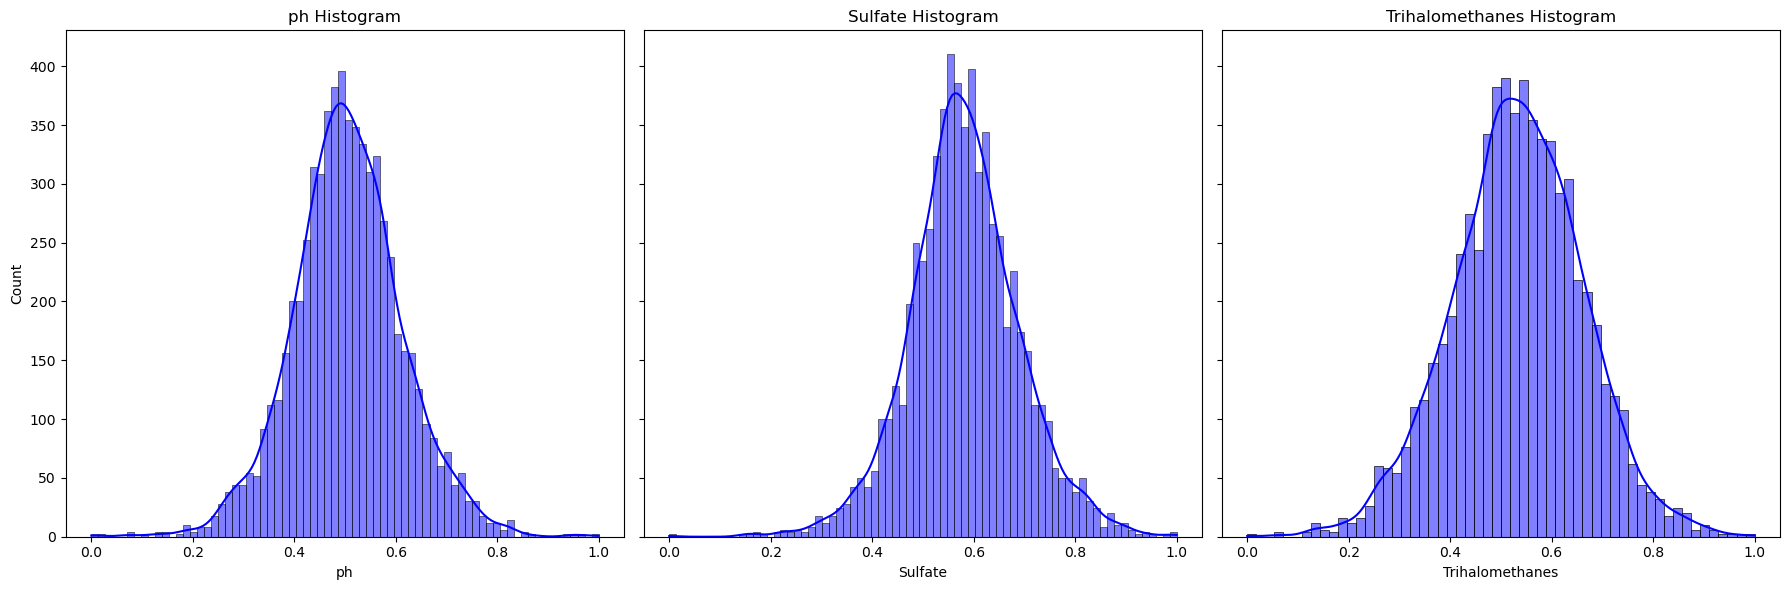

In [10]:
# Create subplots using Seaborn
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Features to plot
features = [df_clean['ph'], df_clean['Sulfate'], df_clean['Trihalomethanes']]

# Plot histograms for each feature
for i, feature in enumerate(features):
    sns.histplot(data=feature, ax=axes[i], kde=True, color='blue', stat='count')
    axes[i].set_title(f'{feature.name} Histogram')

plt.tight_layout()
plt.show()

In [11]:
# depart labels from features
vY = df_clean['Potability']
mX = df_clean.drop(columns=['Potability'])

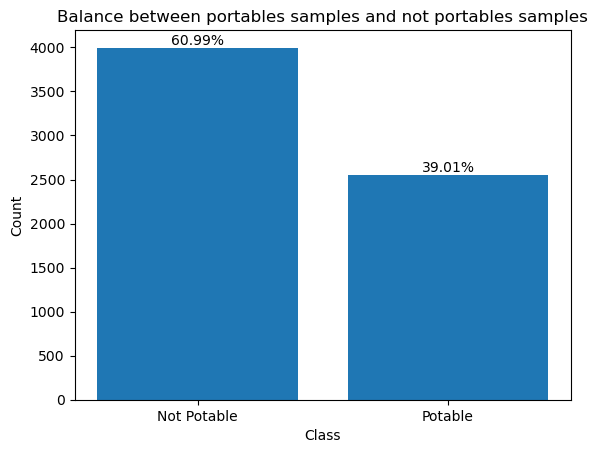

In [12]:
# checking if the data is balanced
classes_counts = vY.value_counts()
plt.bar(classes_counts.index, classes_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Balance between portables samples and not portables samples')
plt.xticks(classes_counts.index, ['Not Potable', 'Potable'])
total = sum(classes_counts)
for index, value in classes_counts.items():
    percentage = (value / total) * 100
    plt.text(index, value, f'{percentage:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

In [13]:
smote = SMOTE(random_state=42)
x_balanced, y_balanced = smote.fit_resample(mX.copy(), vY.copy())

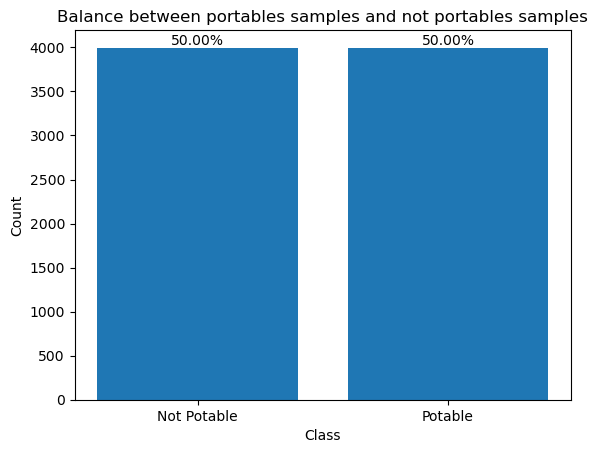

In [14]:
classes_counts = y_balanced.value_counts()
plt.bar(classes_counts.index, classes_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Balance between portables samples and not portables samples')
plt.xticks(classes_counts.index, ['Not Potable', 'Potable'])
total = sum(classes_counts)
for index, value in classes_counts.items():
    percentage = (value / total) * 100
    plt.text(index, value, f'{percentage:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

In [15]:
# Assuming x_balanced and y_balanced are pandas DataFrames or NumPy arrays
# Convert them to pandas DataFrames if they are NumPy arrays
x_balanced_df = pd.DataFrame(x_balanced)
y_balanced_df = pd.DataFrame(y_balanced)

# Concatenate x_balanced and y_balanced along columns (axis=1)
data = pd.concat([x_balanced_df, y_balanced_df], axis=1)

# Save the data to a CSV file
save_preprocessed_data_to_folder(data)
